#  AL Data — Exploratory Data Analysis (EDA)

This notebook performs a structured EDA on **American Lumber (AL) Data** using the accompanying **AL Legend**.
It will:
- Load the AL dataset and legend
- Clean and parse the legend
- Classify columns into **categorical**, **numeric**, and **date** groups
- Run EDA for each group (summary stats, missing values, top-k plots, histograms/boxplots, time trends)
- Create derived metrics (e.g., Gross Margin, Freight differences)
- Save all artifacts (plots and CSVs) to an `eda_output/` folder

> **Note:** Uses only `pandas` and `matplotlib` (no seaborn). Each chart is a single-plot figure.


In [1]:
# %% Setup paths & imports

# === Config: set your paths here ===
AL_DATA_CSV   = r"/Users/nitaishah/Desktop/STAT-683/Data/Data_Split/AL/AL Data .csv"    # <-- change if needed
AL_LEGEND_CSV = r"/Users/nitaishah/Desktop/STAT-683/Data/Data_Split/AL/AL Legend.csv"   # <-- change if needed

# Output directory
from pathlib import Path
OUTDIR = Path("./eda_output")
OUTDIR.mkdir(parents=True, exist_ok=True)

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib: one chart per figure, no explicit colors or styles
plt.rcParams.update({
    "figure.figsize": (9, 5),
    "axes.grid": True
})

print("Output directory:", OUTDIR.resolve())


Output directory: /Users/nitaishah/Desktop/STAT-683/EDA/AL/eda_output


In [2]:
# %% Load AL data & legend

# === Load data ===
al_df = pd.read_csv(AL_DATA_CSV)
legend_df_raw = pd.read_csv(AL_LEGEND_CSV)

print("AL Data shape:", al_df.shape)
print("Legend raw shape:", legend_df_raw.shape)
display(al_df.head(3))
display(legend_df_raw.head(5))


AL Data shape: (15559, 46)
Legend raw shape: (48, 3)


,poRecordID,AljexProNum,VendorCID,Mill,BuyerName,ContractPurchase,poType,LinkToNo,Salesman,FreightPO,...,OriginAddress2,OriginCity,OriginST,OriginZip,CustomerName,DestAddress1,DestAddress2,DestCity,DestST,DestZip
0,478039.0,34417.0,15426.0,"Vicksburg Forest Products, LLC (Vicksburg, MS)","Oney, Donnie",1.0,Direct PO,194480.0,"Spann, Colby",486741.0,...,NaN,Vicksburg,MS,39183,"Apache Products, Inc",1910 US Hwy 96 N,NaN,Silsbee,TX,77656
1,478039.0,34417.0,15426.0,"Vicksburg Forest Products, LLC (Vicksburg, MS)","Oney, Donnie",1.0,Direct PO,194480.0,"Spann, Colby",486741.0,...,NaN,Vicksburg,MS,39183,"Apache Products, Inc",1910 US Hwy 96 N,NaN,Silsbee,TX,77656
2,478039.0,34417.0,15426.0,"Vicksburg Forest Products, LLC (Vicksburg, MS)","Oney, Donnie",1.0,Direct PO,194480.0,"Spann, Colby",486741.0,...,NaN,Vicksburg,MS,39183,"Apache Products, Inc",1910 US Hwy 96 N,NaN,Silsbee,TX,77656


,American Lumber Legend:,Unnamed: 1,Unnamed: 2
0,NaN,NaN,NaN
1,poRecordID,"Lumber PO number, there could be multiple inst...",NaN
2,AljexProNumber,unique number assigned to the load in dispatch...,NaN
3,VendorCID,unique number assigned to the mill the load wa...,NaN
4,Mill,name of Mill the load was purchased from,NaN


In [3]:
# %% Clean & parse legend

# === Clean & parse legend ===
# Keep first two columns: Column name + Description
legend_df = legend_df_raw.iloc[:, :2].copy()
legend_df.columns = ["Column", "Description"]
legend_df = legend_df.dropna(subset=["Column"]).reset_index(drop=True)

# Strip spaces / unify case for matching
legend_df["Column_norm"] = legend_df["Column"].astype(str).str.strip().str.lower()
al_cols_norm = [c.strip().lower() for c in al_df.columns]

# Quick preview of cleaned legend
display(legend_df.head(10))

# Save cleaned legend for reference
legend_df[["Column","Description"]].to_csv(OUTDIR / "AL_Legend_Cleaned.csv", index=False, encoding="utf-8-sig")

print("Saved:", OUTDIR / "AL_Legend_Cleaned.csv")


,Column,Description,Column_norm
0,poRecordID,"Lumber PO number, there could be multiple inst...",porecordid
1,AljexProNumber,unique number assigned to the load in dispatch...,aljexpronumber
2,VendorCID,unique number assigned to the mill the load wa...,vendorcid
3,Mill,name of Mill the load was purchased from,mill
4,BuyerName,name of American Lumber buyer that bought load,buyername
5,ContractPurchase,1 = Contract / 0 = Non-Contract,contractpurchase
6,poType,"Direct POs - bought from mill, shipped direct ...",potype
7,LinkToNo,the Sales Order tied to the PO when sold as a ...,linktono
8,Salesman,name of saleman associated with the load,salesman
9,FreightPO,FreightPO number,freightpo


Saved: eda_output/AL_Legend_Cleaned.csv


In [4]:
# %% Classify columns

# === Column classification (categorical / numeric / date) ===
categorical, numeric, date_cols = [], [], []

# Helper to get description for a column (case-insensitive)
def get_desc(col):
    key = col.strip().lower()
    m = legend_df.loc[legend_df["Column_norm"] == key, "Description"].values
    if len(m) > 0 and isinstance(m[0], str):
        return m[0]
    return ""

for col in al_df.columns:
    desc_text = get_desc(col).lower()

    if "date" in desc_text:
        date_cols.append(col)
    elif any(word in desc_text for word in ["name", "city", "state", "zip", "description", "address", "mill", "buyer"]):
        categorical.append(col)
    elif str(al_df[col].dtype) in ["float64", "int64"]:
        numeric.append(col)
    else:
        # Fallback
        categorical.append(col)

print("Categorical ({}):".format(len(categorical)), categorical)
print("Numeric ({}):".format(len(numeric)), numeric)
print("Date ({}):".format(len(date_cols)), date_cols)

# Save classification
pd.DataFrame({"categorical": pd.Series(categorical)}).to_csv(OUTDIR / "AL_Categorical_Columns.csv", index=False)
pd.DataFrame({"numeric": pd.Series(numeric)}).to_csv(OUTDIR / "AL_Numeric_Columns.csv", index=False)
pd.DataFrame({"date": pd.Series(date_cols)}).to_csv(OUTDIR / "AL_Date_Columns.csv", index=False)

print("Saved column lists to:", OUTDIR)


Categorical (24): ['VendorCID', 'Mill', 'BuyerName', 'poType', 'Salesman', 'ShipVia', 'ItemDescription', 'Grade', 'Species', 'FreightFactor', 'PurchaseUOM', 'DATRate', 'SaleUOM', 'OriginAddress1', 'OriginAddress2', 'OriginCity', 'OriginST', 'OriginZip', 'CustomerName', 'DestAddress1', 'DestAddress2', 'DestCity', 'DestST', 'DestZip']
Numeric (19): ['poRecordID', 'AljexProNum', 'ContractPurchase', 'LinkToNo', 'FreightPO', 'ItemID', 'ConvBF', 'PurchasePrice', 'LumberCost', 'BF', 'Active', 'EstFreight', 'ActFreightCost', 'CarrierCost', 'FreightOutByLine', 'ReceivingFee', 'ContributionFee', 'TotalCost', 'SalePrice']
Date (3): ['CallReadyDate', 'PickUpDate', 'DeliveredDate']
Saved column lists to: eda_output


In [5]:
# %% Info & missing values

# === Basic info & missing values ===
info_text = []
info_text.append(f"Rows: {al_df.shape[0]}, Columns: {al_df.shape[1]}")

# Dtypes summary
dtype_counts = al_df.dtypes.astype(str).value_counts().to_dict()
info_text.append(f"Dtypes: {dtype_counts}")

# Missing value counts
missing = al_df.isna().sum().sort_values(ascending=False)
missing.to_csv(OUTDIR / "AL_Missing_Values.csv", header=["missing_count"])

print("\n".join(info_text))
display(missing.head(20))
print("Saved:", OUTDIR / "AL_Missing_Values.csv")


Rows: 15559, Columns: 46
Dtypes: {'object': 25, 'float64': 21}


DestAddress2       15402
OriginAddress2     15328
ReceivingFee       11100
FreightFactor       9967
FreightPO           6312
PickUpDate          5611
CarrierCost         5523
AljexProNum         5519
SaleUOM             4462
SalePrice           4462
CustomerName        4462
DATRate             4462
ContributionFee     4462
LinkToNo            4460
Salesman            4354
Grade                903
DestZip              270
DestAddress1         267
DestCity             267
DestST               267
dtype: int64

Saved: eda_output/AL_Missing_Values.csv


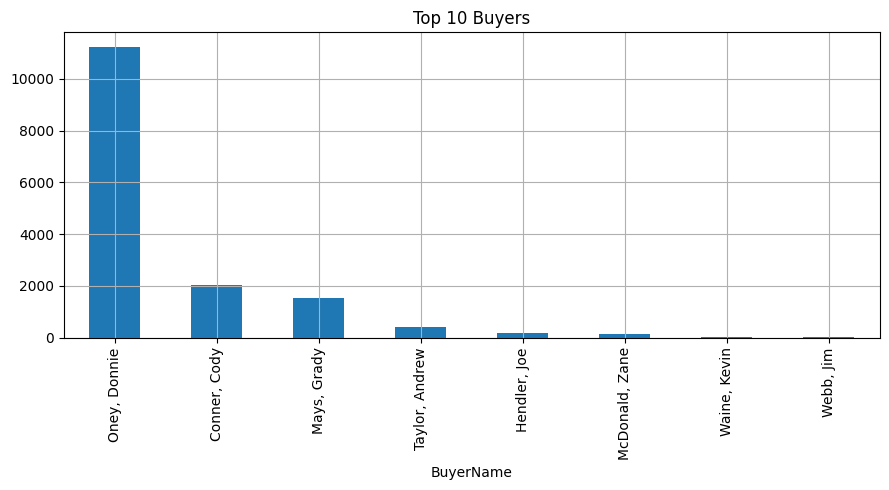

Saved plot: eda_output/BuyerName_top10.png


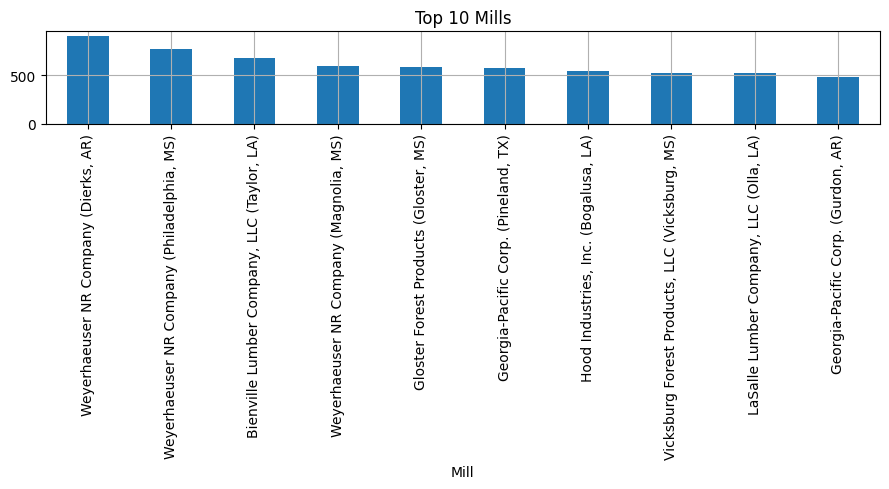

Saved plot: eda_output/Mill_top10.png


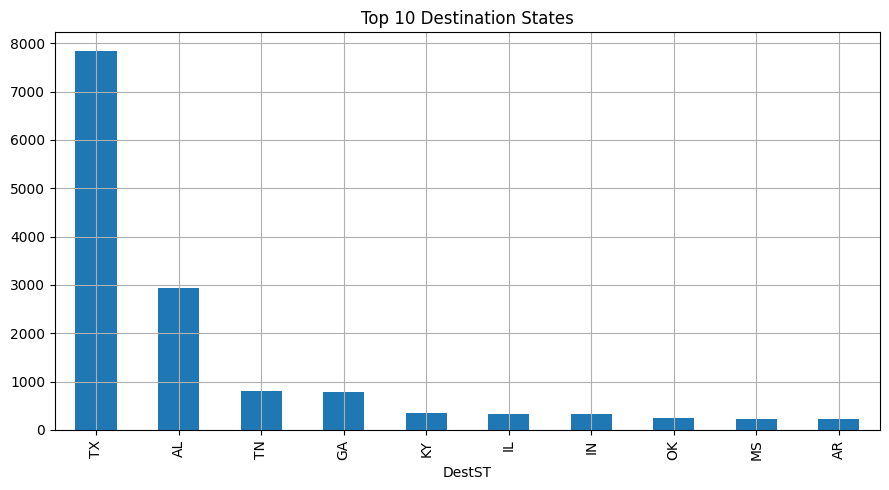

Saved plot: eda_output/DestST_top10.png
Saved frequency tables for all categorical columns.


In [6]:
# %% Categorical EDA

# === Categorical EDA ===
def top_k_bar(series, title, k=10, fname="plot.png"):
    vc = series.value_counts().head(k)
    plt.figure()
    vc.plot(kind="bar")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(OUTDIR / fname, dpi=150)
    plt.show()

# Safe helpers for columns that may or may not exist
def plot_if_exists(df, col, title, k=10):
    if col in df.columns:
        top_k_bar(df[col].dropna(), title=title, k=k, fname=f"{col}_top{k}.png")
        print("Saved plot:", OUTDIR / f"{col}_top{k}.png")

# Examples commonly present in AL data
plot_if_exists(al_df, "BuyerName", "Top 10 Buyers", 10)
plot_if_exists(al_df, "Mill", "Top 10 Mills", 10)
plot_if_exists(al_df, "DestST", "Top 10 Destination States", 10)

# Save full frequency tables for all categorical columns
for col in categorical:
    freq = al_df[col].value_counts(dropna=False)
    freq.to_csv(OUTDIR / f"freq_{col}.csv", header=["count"])
print("Saved frequency tables for all categorical columns.")


,count,mean,std,min,25%,50%,75%,max
poRecordID,15558.0,493263.727150,5867.734054,472779.00000,488349.25,492852.00000,498138.75,504699.0000
AljexProNum,10040.0,38555.014243,2644.455408,32350.00000,36217.00,38447.50000,40884.25,43185.0000
ContractPurchase,15558.0,0.269379,0.443651,0.00000,0.00,0.00000,1.00,1.0000
LinkToNo,11099.0,199148.348410,3094.649918,188486.00000,196389.00,199082.00000,201872.00,204586.0000
FreightPO,9247.0,494763.336974,5762.855581,484754.00000,489607.50,494342.00000,499599.00,504867.0000
ItemID,15558.0,1502.557270,1030.214826,1002.00000,1073.00,1150.00000,1347.00,6108.0000
ConvBF,15558.0,13.134715,8.812084,0.27777,8.00,10.66667,16.00,213.3333
PurchasePrice,15558.0,310.111773,154.851603,0.01000,235.00,285.00000,353.00,4666.6660
LumberCost,15557.0,3174.357806,2856.164120,-36505.93000,1090.64,2342.06000,4818.20,60513.0430
BF,15558.0,12866.332819,8799.087032,0.00000,4992.00,10667.00000,23040.00,112889.0000


Saved: eda_output/AL_Numeric_Describe.csv


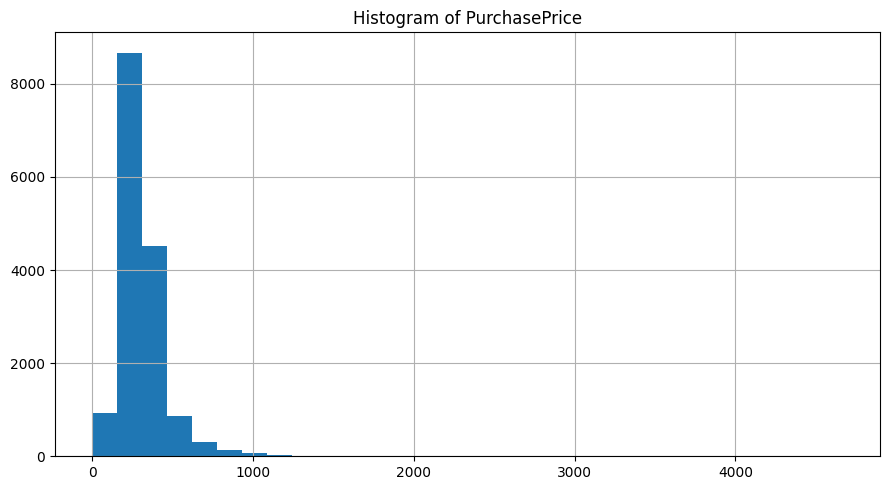

Saved plot: eda_output/hist_PurchasePrice.png


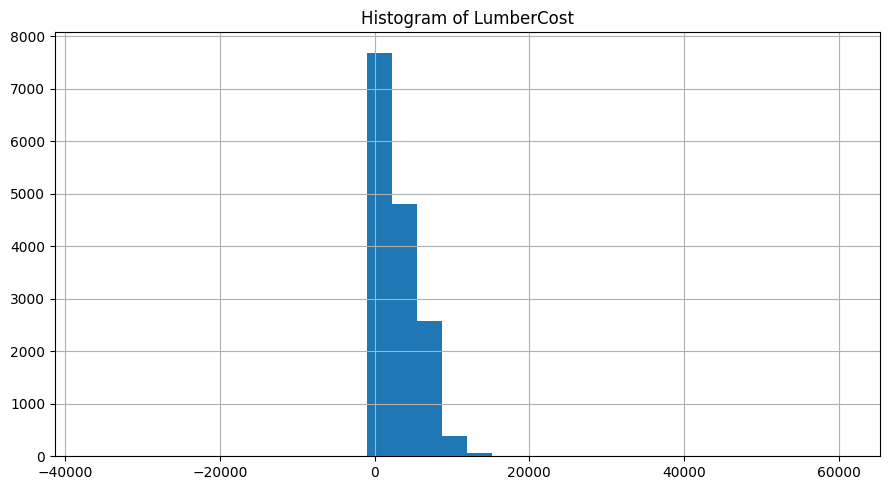

Saved plot: eda_output/hist_LumberCost.png


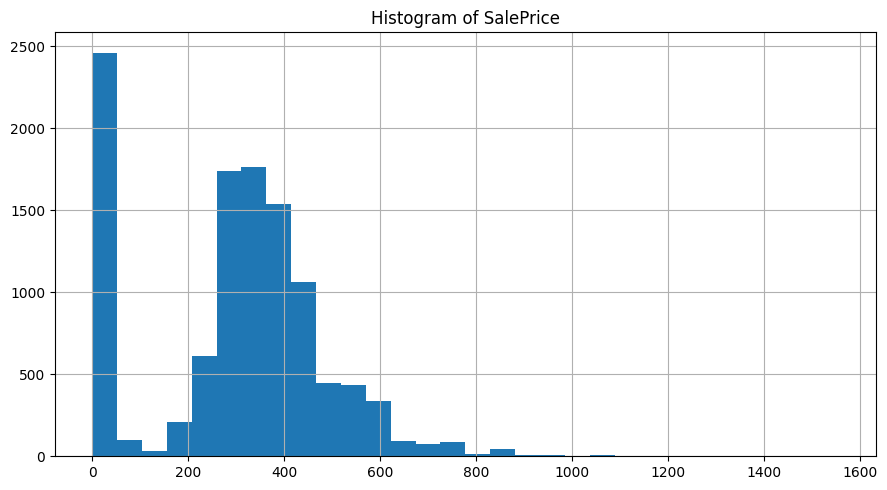

Saved plot: eda_output/hist_SalePrice.png


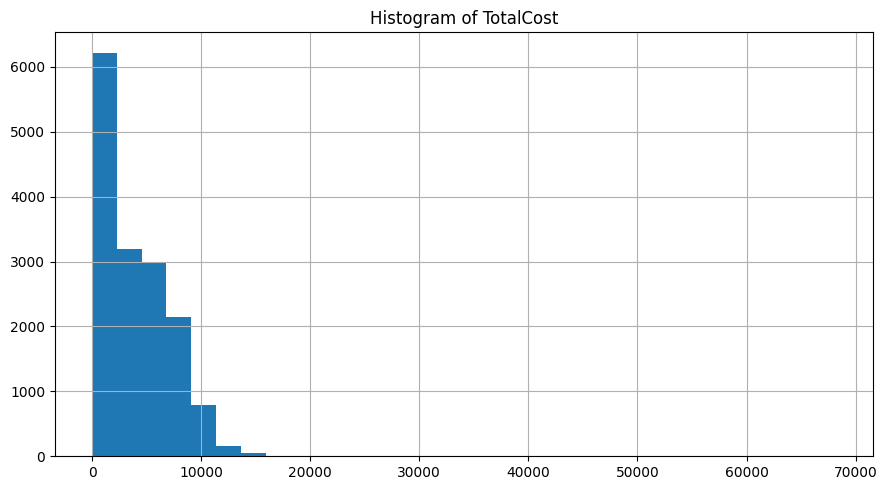

Saved plot: eda_output/hist_TotalCost.png


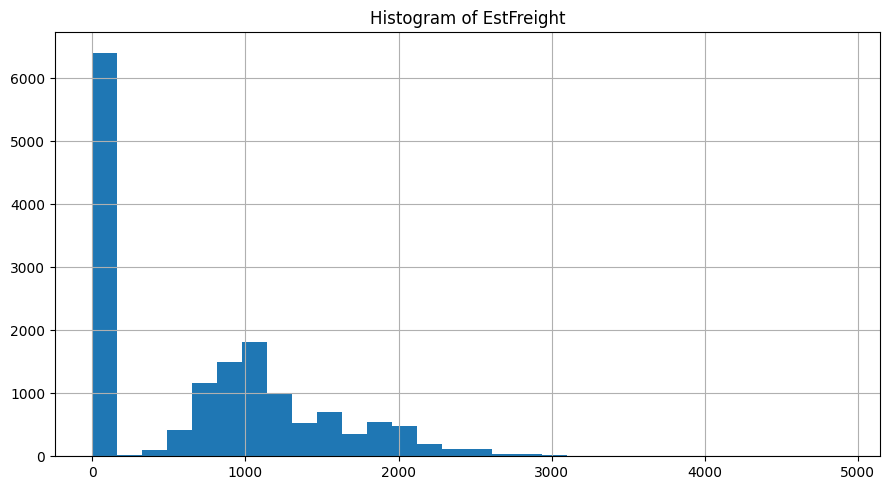

Saved plot: eda_output/hist_EstFreight.png


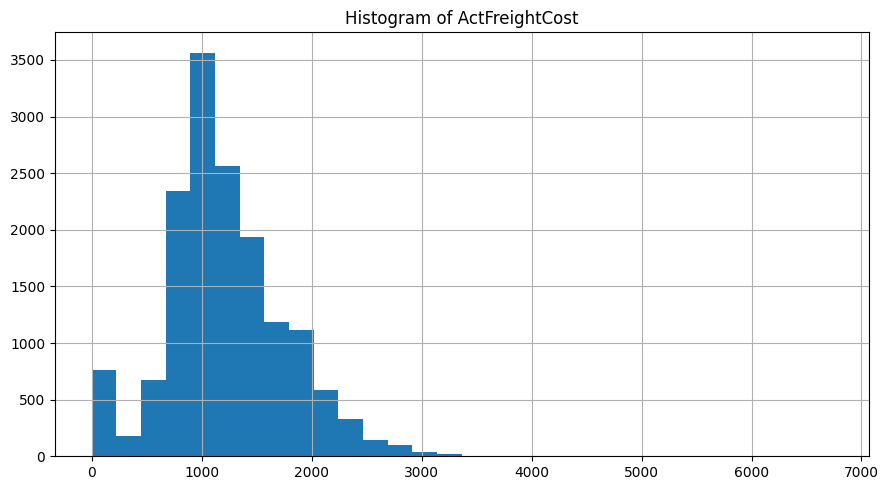

Saved plot: eda_output/hist_ActFreightCost.png


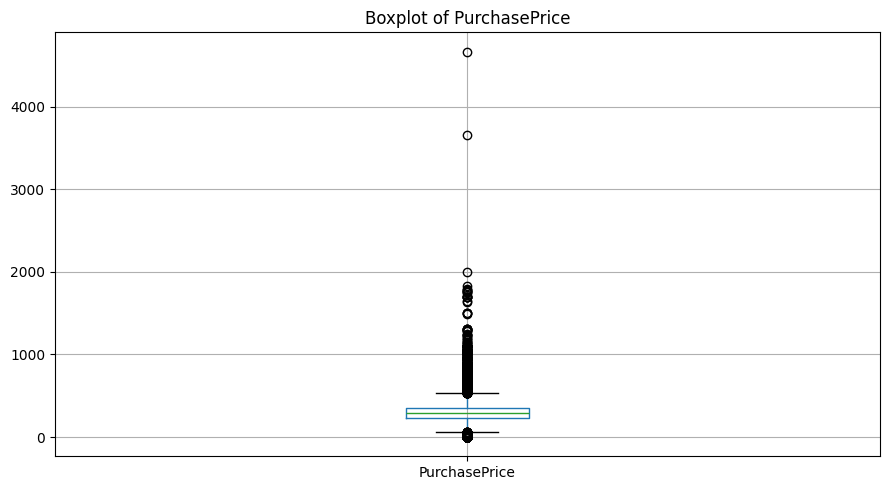

Saved plot: eda_output/box_PurchasePrice.png


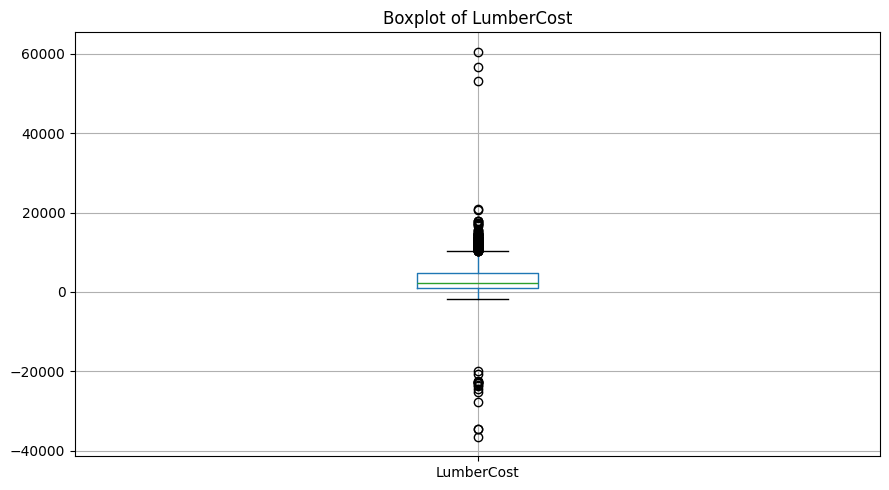

Saved plot: eda_output/box_LumberCost.png


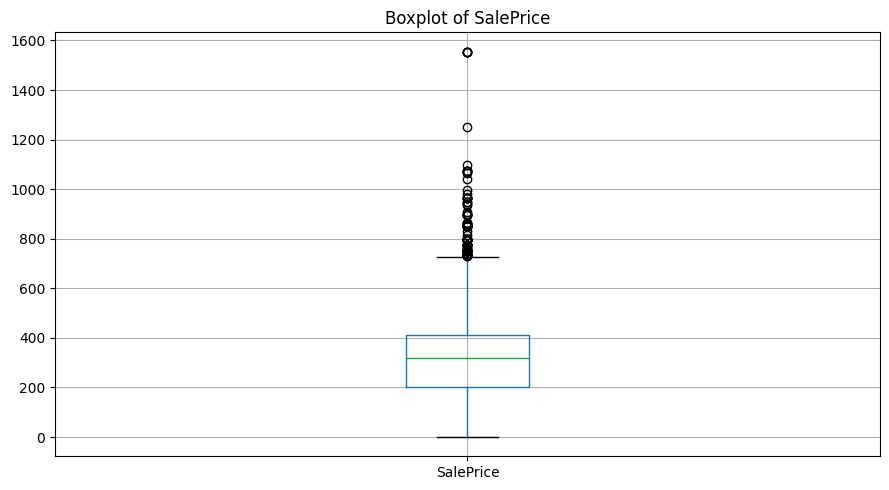

Saved plot: eda_output/box_SalePrice.png


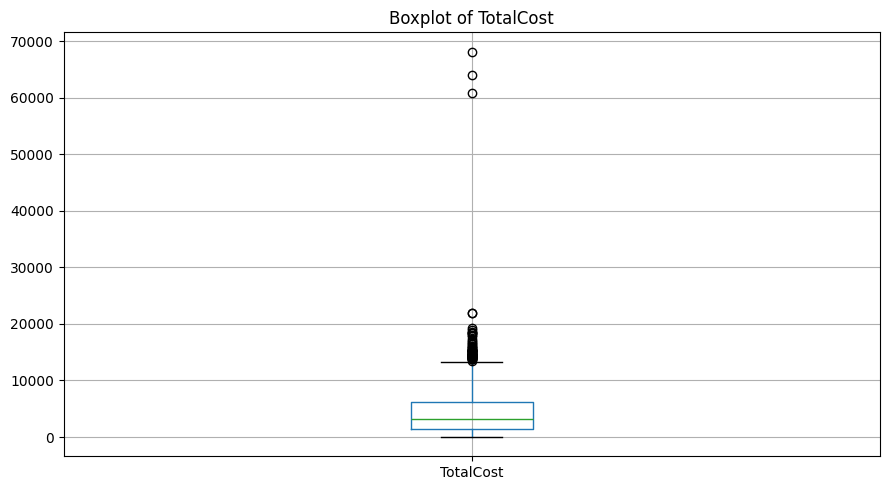

Saved plot: eda_output/box_TotalCost.png


,poRecordID,AljexProNum,ContractPurchase,LinkToNo,FreightPO,ItemID,ConvBF,PurchasePrice,LumberCost,BF,Active,EstFreight,ActFreightCost,CarrierCost,FreightOutByLine,ReceivingFee,ContributionFee,TotalCost,SalePrice
poRecordID,1.000000,0.967977,-0.179027,0.976879,0.968184,0.015045,0.030246,-0.047846,0.004507,0.114877,NaN,0.078677,0.071391,0.071364,0.078125,0.130370,0.084242,0.030763,-0.058979
AljexProNum,0.967977,1.000000,-0.082271,0.991246,0.997770,0.000088,0.031354,-0.039133,-0.055478,0.048858,NaN,0.093479,0.114091,0.074910,0.059814,-0.014096,0.055417,-0.027620,-0.069529
ContractPurchase,-0.179027,-0.082271,1.000000,-0.049241,-0.102306,-0.194575,-0.089898,-0.144305,-0.294561,-0.291724,NaN,-0.201477,-0.010719,-0.032996,-0.130458,-0.277521,-0.236269,-0.312779,0.028810
LinkToNo,0.976879,0.991246,-0.049241,1.000000,0.989962,-0.050277,0.025213,-0.070526,-0.079047,0.050932,NaN,0.029921,0.066507,0.058657,0.072510,NaN,0.052900,-0.053396,-0.065015
FreightPO,0.968184,0.997770,-0.102306,0.989962,1.000000,0.000951,0.036723,-0.035563,-0.053833,0.052893,NaN,0.101517,0.115249,0.110949,0.059666,-0.003210,0.056856,-0.025761,-0.064417
ItemID,0.015045,0.000088,-0.194575,-0.050277,0.000951,1.000000,-0.011272,0.320364,0.236803,0.026786,NaN,0.055165,-0.071577,0.033365,0.047048,0.182724,-0.035096,0.228886,0.008071
ConvBF,0.030246,0.031354,-0.089898,0.025213,0.036723,-0.011272,1.000000,0.249173,0.008812,-0.134612,NaN,0.024322,0.041917,0.011055,-0.062656,-0.136521,-0.131174,-0.015332,0.230146
PurchasePrice,-0.047846,-0.039133,-0.144305,-0.070526,-0.035563,0.320364,0.249173,1.000000,0.313566,-0.097553,NaN,0.049802,-0.003528,0.056192,-0.040078,-0.045167,-0.136922,0.268543,0.087358
LumberCost,0.004507,-0.055478,-0.294561,-0.079047,-0.053833,0.236803,0.008812,0.313566,1.000000,0.709198,NaN,0.079868,-0.022615,-0.106241,0.022670,0.672959,0.711951,0.935861,0.055935
BF,0.114877,0.048858,-0.291724,0.050932,0.052893,0.026786,-0.134612,-0.097553,0.709198,1.000000,NaN,0.152022,0.111580,-0.016744,0.425327,0.999380,0.993519,0.814405,-0.075393


Saved: eda_output/AL_Numeric_Correlation.csv


In [7]:
# %% Numeric EDA

# === Numeric EDA ===
# Summary stats
desc = al_df[numeric].describe().T if len(numeric) > 0 else pd.DataFrame()
if not desc.empty:
    desc.to_csv(OUTDIR / "AL_Numeric_Describe.csv", encoding="utf-8-sig")
    display(desc.head(10))
    print("Saved:", OUTDIR / "AL_Numeric_Describe.csv")

# Histograms for a few key numeric columns if present
def hist_if_exists(df, col, bins=30):
    if col in df.columns:
        plt.figure()
        df[col].dropna().hist(bins=bins)
        plt.title(f"Histogram of {col}")
        plt.tight_layout()
        plt.savefig(OUTDIR / f"hist_{col}.png", dpi=150)
        plt.show()
        print("Saved plot:", OUTDIR / f"hist_{col}.png")

# Common numeric columns in AL
for col in ["PurchasePrice", "LumberCost", "SalePrice", "TotalCost", "EstFreight", "ActFreightCost"]:
    hist_if_exists(al_df, col)

# Boxplots to inspect outliers (one per figure)
def box_if_exists(df, col):
    if col in df.columns:
        plt.figure()
        df[[col]].boxplot()
        plt.title(f"Boxplot of {col}")
        plt.tight_layout()
        plt.savefig(OUTDIR / f"box_{col}.png", dpi=150)
        plt.show()
        print("Saved plot:", OUTDIR / f"box_{col}.png")

for col in ["PurchasePrice", "LumberCost", "SalePrice", "TotalCost"]:
    box_if_exists(al_df, col)

# Correlations among numeric columns (saved as CSV)
if len(numeric) > 1:
    corr = al_df[numeric].corr(numeric_only=True)
    corr.to_csv(OUTDIR / "AL_Numeric_Correlation.csv", encoding="utf-8-sig")
    display(corr)
    print("Saved:", OUTDIR / "AL_Numeric_Correlation.csv")


GrossMargin stats saved: eda_output/GrossMargin_Describe.csv


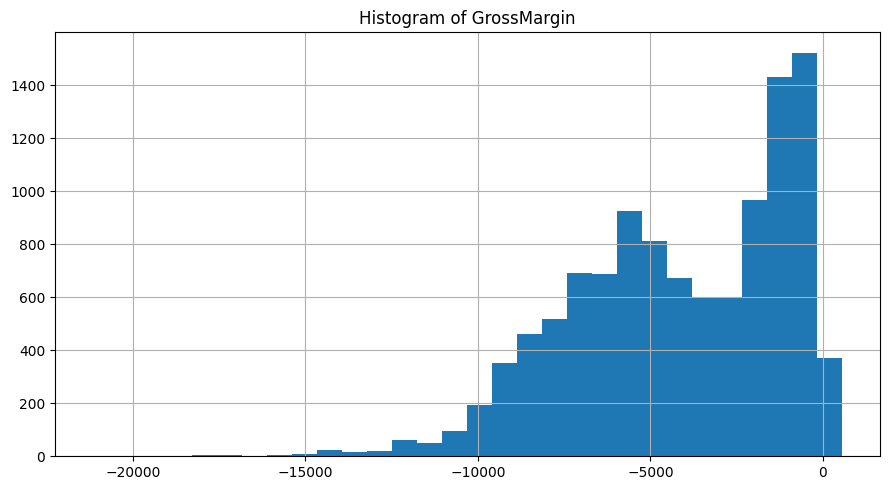

Saved plot: eda_output/hist_GrossMargin.png
FreightDiff stats saved: eda_output/FreightDiff_Describe.csv


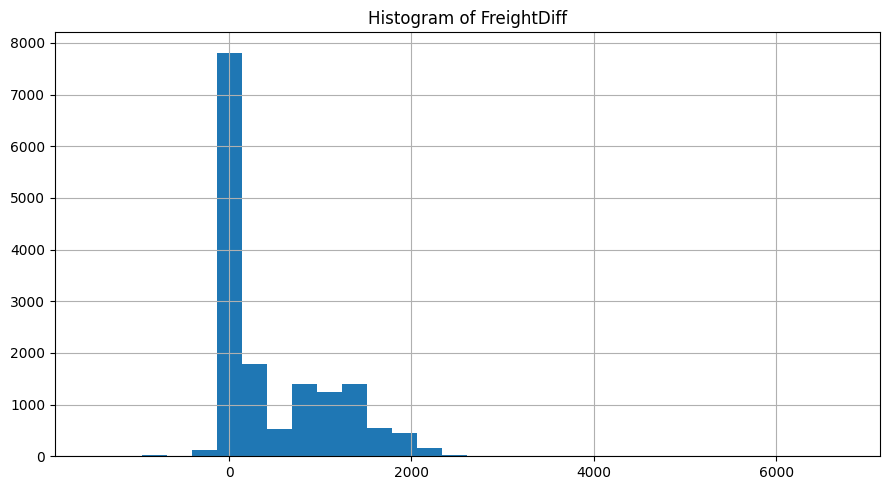

Saved plot: eda_output/hist_FreightDiff.png
Saved: eda_output/AL_Data_with_Derived.csv


In [8]:
# %% Derived metrics

# === Derived metrics ===
# Gross Margin
if all(c in al_df.columns for c in ["SalePrice","TotalCost"]):
    al_df["GrossMargin"] = al_df["SalePrice"] - al_df["TotalCost"]
    gm_desc = al_df["GrossMargin"].describe()
    gm_desc.to_csv(OUTDIR / "GrossMargin_Describe.csv", header=["value"])
    print("GrossMargin stats saved:", OUTDIR / "GrossMargin_Describe.csv")
    plt.figure()
    al_df["GrossMargin"].dropna().hist(bins=30)
    plt.title("Histogram of GrossMargin")
    plt.tight_layout()
    plt.savefig(OUTDIR / "hist_GrossMargin.png", dpi=150)
    plt.show()
    print("Saved plot:", OUTDIR / "hist_GrossMargin.png")

# Freight difference (Actual - Estimated)
if all(c in al_df.columns for c in ["ActFreightCost","EstFreight"]):
    al_df["FreightDiff"] = al_df["ActFreightCost"] - al_df["EstFreight"]
    fd_desc = al_df["FreightDiff"].describe()
    fd_desc.to_csv(OUTDIR / "FreightDiff_Describe.csv", header=["value"])
    print("FreightDiff stats saved:", OUTDIR / "FreightDiff_Describe.csv")
    plt.figure()
    al_df["FreightDiff"].dropna().hist(bins=30)
    plt.title("Histogram of FreightDiff")
    plt.tight_layout()
    plt.savefig(OUTDIR / "hist_FreightDiff.png", dpi=150)
    plt.show()
    print("Saved plot:", OUTDIR / "hist_FreightDiff.png")

# Save a copy with derived fields
al_df.to_csv(OUTDIR / "AL_Data_with_Derived.csv", index=False, encoding="utf-8-sig")
print("Saved:", OUTDIR / "AL_Data_with_Derived.csv")


,column,min,max,missing
0,CallReadyDate,2024-11-04,2025-09-05,42
1,PickUpDate,2024-11-08,2025-09-03,11276
2,DeliveredDate,2025-01-01,2025-09-04,1


Saved: eda_output/AL_Date_Coverage.csv


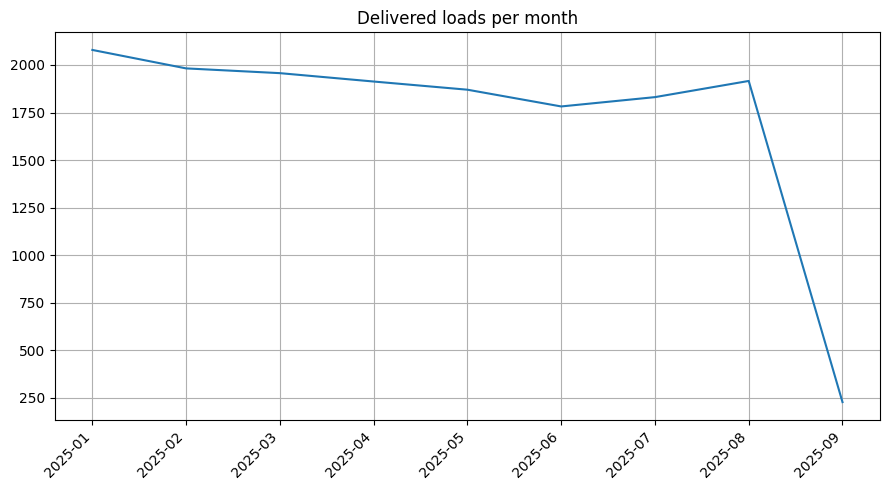

Saved: eda_output/line_Delivered_per_month.png


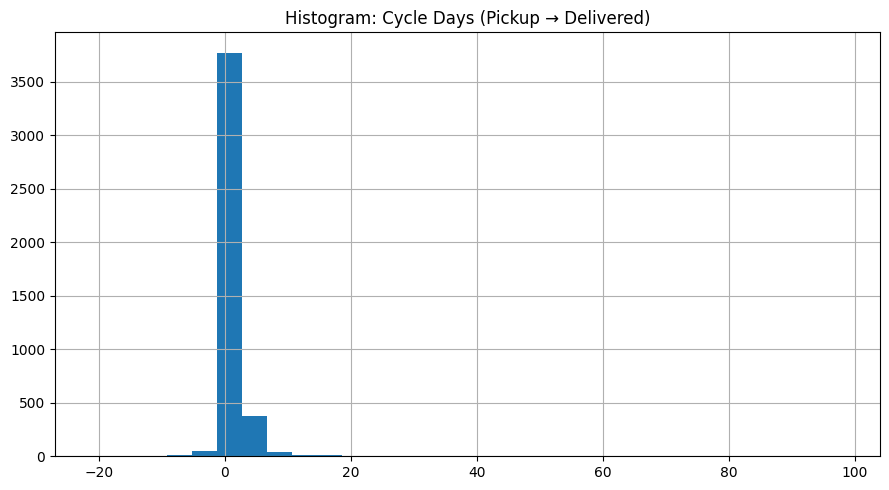

Saved: eda_output/hist_CycleDays_Pickup_to_Delivered.png


In [9]:
# %% Dates & time-series analysis

# === Date handling & time-based analysis ===
from datetime import timedelta

# Convert date columns safely
for col in date_cols:
    al_df[col] = pd.to_datetime(al_df[col], errors="coerce")

# Save date coverage
date_coverage = []
for col in date_cols:
    date_coverage.append({
        "column": col,
        "min": al_df[col].min(),
        "max": al_df[col].max(),
        "missing": int(al_df[col].isna().sum())
    })
date_cov_df = pd.DataFrame(date_coverage)
date_cov_df.to_csv(OUTDIR / "AL_Date_Coverage.csv", index=False, encoding="utf-8-sig")
display(date_cov_df)
print("Saved:", OUTDIR / "AL_Date_Coverage.csv")

# Monthly delivery counts if DeliveredDate exists
if "DeliveredDate" in date_cols:
    monthly = al_df["DeliveredDate"].dt.to_period("M").value_counts().sort_index()
    monthly = monthly.rename_axis("month").reset_index(name="count")
    monthly.to_csv(OUTDIR / "Delivered_monthly_counts.csv", index=False, encoding="utf-8-sig")
    plt.figure()
    plt.plot(monthly["month"].astype(str), monthly["count"])
    plt.title("Delivered loads per month")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(OUTDIR / "line_Delivered_per_month.png", dpi=150)
    plt.show()
    print("Saved:", OUTDIR / "line_Delivered_per_month.png")

# Cycle times if we have PickUpDate and DeliveredDate
if all(c in date_cols for c in ["PickUpDate","DeliveredDate"]):
    valid = al_df.dropna(subset=["PickUpDate","DeliveredDate"]).copy()
    valid["CycleDays_Pickup_to_Delivered"] = (valid["DeliveredDate"] - valid["PickUpDate"]).dt.days
    valid["CycleDays_Pickup_to_Delivered"].to_csv(OUTDIR / "CycleDays_Pickup_to_Delivered.csv", index=False, header=["days"])
    plt.figure()
    valid["CycleDays_Pickup_to_Delivered"].dropna().hist(bins=30)
    plt.title("Histogram: Cycle Days (Pickup → Delivered)")
    plt.tight_layout()
    plt.savefig(OUTDIR / "hist_CycleDays_Pickup_to_Delivered.png", dpi=150)
    plt.show()
    print("Saved:", OUTDIR / "hist_CycleDays_Pickup_to_Delivered.png")


In [10]:
# %% Summary report & wrap-up

# === Save a lightweight EDA summary report ===
summary = {
    "rows": al_df.shape[0],
    "columns": al_df.shape[1],
    "n_categorical": len(categorical),
    "n_numeric": len(numeric),
    "n_date": len(date_cols),
    "missing_any": int(al_df.isna().any(axis=1).sum()),
    "missing_total_cells": int(al_df.isna().sum().sum())
}
summary_df = pd.DataFrame([summary])
summary_df.to_csv(OUTDIR / "EDA_Summary_AL.csv", index=False, encoding="utf-8-sig")
display(summary_df)
print("Saved:", OUTDIR / "EDA_Summary_AL.csv")
print("\nAll outputs written to:", OUTDIR.resolve())


,rows,columns,n_categorical,n_numeric,n_date,missing_any,missing_total_cells
0,15559,48,24,19,3,15559,118064


Saved: eda_output/EDA_Summary_AL.csv

All outputs written to: /Users/nitaishah/Desktop/STAT-683/EDA/AL/eda_output
